In [1]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from mc_plot_utils import MCMCResult

In [6]:
import mc_plot_utils

In [7]:
df = pd.read_csv("yield_fits.tsv", sep=r"\s+", comment="#")
df

,model,y0,zeta0,zeta0_err,zeta1,zeta1_err
0,fruity,3.110,3.7,0.3,-3.5,0.3
1,aton,-0.009,1.0,1.9,-10.0,3.0
2,monash,2.960,2.3,0.5,-11.0,1.0
3,nugrid,9.250,8.1,1.9,-4.6,1.7
4,fruity_mf0.5,2.830,3.3,0.2,-1.8,0.2
5,fruity_mf0.7,3.600,4.2,0.3,-3.1,0.3
6,fruity_mf1.5,3.110,3.4,0.2,-3.0,0.2


In [8]:
vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", mass_factor=0.7)
surp.yields.calc_y(surp.Z_SUN, kind="agb") * 1e3

0.3604729682654721

In [9]:
yagb_props = {}

for _, row in df.iterrows():
    yagb_props[row.model] = {
        "y0": row.y0 * 1e-4,
        "y_a": row.zeta0 * 1e-4,
        "zeta_a": row.zeta1 * 1e-4,
    }

yagb_props["analytic"] = {
    "y0": 1e-3,
    "y_a": 1e-3,
    "zeta_a": 1e-3
}

yagb_props

{'fruity': {'y0': 0.000311, 'y_a': 0.00037000000000000005, 'zeta_a': -0.00035},
 'aton': {'y0': -9e-07, 'y_a': 0.0001, 'zeta_a': -0.001},
 'monash': {'y0': 0.000296, 'y_a': 0.00022999999999999998, 'zeta_a': -0.0011},
 'nugrid': {'y0': 0.000925, 'y_a': 0.00081, 'zeta_a': -0.00045999999999999996},
 'fruity_mf0.5': {'y0': 0.000283, 'y_a': 0.00033, 'zeta_a': -0.00018},
 'fruity_mf0.7': {'y0': 0.00036, 'y_a': 0.00042, 'zeta_a': -0.00031},
 'fruity_mf1.5': {'y0': 0.000311,
  'y_a': 0.00034,
  'zeta_a': -0.00030000000000000003},
 'analytic': {'y0': 0.001, 'y_a': 0.001, 'zeta_a': 0.001}}

In [10]:
def load_model(filename, props, test=False, burn=0):
    y0 = props["y0"],
    y_a = props["y_a"]
    zeta_a = props["zeta_a"]
    
    if test:
        result = MCMCResult.from_test_file(filename, burn=burn)
    else:
        result = MCMCResult.from_file("../models/mcmc_models_2d/" + filename + "/", y0=y0, burn=burn, y_a=y_a, zeta_a=zeta_a)
    return result

In [11]:
def get_params(filename):
    df = pd.read_csv("../models/mcmc_models_2d/" + filename + "/mcmc_summary.csv")


    for (i, r) in df.iterrows():
        print(f'{r.parameters:8}\t{r["median"]:0.3f}\t-{r.err_low:0.3f}\t+{r.err_high:0.3f}')


    return df

In [12]:
def get_df_key(df, key):
    try:
        return df[df.parameters == key]["median"].iloc[0]
    except Exception as e:
        return np.nan

In [13]:
def to_log_slope(slope):
    return slope / surp.Z_SUN / surp.yield_models.zeta_to_slope(1)

In [14]:
def make_new_params(df, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")

    y0 = (y0_l + slope)*1e-3
    zeta = 1e-3 * slope / surp.Z_SUN / surp.yield_models.zeta_to_slope(1)
    
    print(f"alpha_c_agb = {alpha:0.2f}" )
    print(f"y0_c_cc = {y0:0.2e}" )
    print(f"zeta_c_cc = {zeta:0.2e}", )
    
    f_agb = yagb_props[study]["y0"] * alpha / (yagb_props[study]["y0"] * alpha + y0)
    print(f"f = {f_agb:0.3f}" )


In [15]:
def make_f_agb(df, f_new, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")
    y0 = (y0_l + slope) * 1e-3
    
    ya = yagb_props[study]["y0"]
    ytot = ya * alpha + y0
    
    f_agb = ya * alpha / ytot

    alpha_new = f_new * ytot / ya

    y0_new = ytot - alpha_new * ya
    f_new_new = ya * alpha_new / ytot

    print(f"y0 = {y0_new:0.3e}" )
    print(f"alpha = {alpha_new:0.3f}" )

    print(f"f = {f_new_new:0.3f}" )


# simple yields

## Making new model parameters

In [93]:
df = get_params("fiducial_constrained")
0.919e-3 + 2.715 * yagb_props["fruity"]["y0"] + 0.902e-3

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008


0.0026653650000000003

In [17]:
df = get_params("fiducial")
print()
make_new_params(df, "fruity")

y0_cc   	1.513	-0.019	+0.018
alpha   	1.549	-0.040	+0.041
zeta_cc 	0.718	-0.009	+0.009

alpha_c_agb = 1.55
y0_c_cc = 2.23e-03
zeta_c_cc = 1.65e-03
f = 0.178


In [16]:
df = get_params("fiducial_2")
print()
make_new_params(df, "fruity")

y0_cc   	1.513	-0.019	+0.019
alpha   	1.549	-0.041	+0.041
zeta_cc 	0.718	-0.009	+0.009

alpha_c_agb = 1.55
y0_c_cc = 2.23e-03
zeta_c_cc = 1.65e-03
f = 0.178


In [68]:
df = get_params("fiducial_sigma")
print()
make_new_params(df, "fruity")

y0_cc   	1.649	-0.038	+0.038
alpha   	1.619	-0.100	+0.101
zeta_cc 	0.543	-0.037	+0.036
sigma_int	0.021	-0.002	+0.002

alpha_c_agb = 1.62
y0_c_cc = 2.19e-03
zeta_c_cc = 1.25e-03
f = 0.187


In [69]:
df = get_params("fiducial_constrained")
print()
make_new_params(df, "fruity")

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008

alpha_c_agb = 2.72
y0_c_cc = 1.82e-03
zeta_c_cc = 2.08e-03
f = 0.317


In [70]:
df = get_params("aton")
print()
make_new_params(df, "aton")

y0_cc   	1.497	-0.020	+0.020
alpha   	1.057	-0.029	+0.029
zeta_cc 	1.122	-0.017	+0.017

alpha_c_agb = 1.06
y0_c_cc = 2.62e-03
zeta_c_cc = 2.58e-03
f = -0.000


In [71]:
df = get_params("monash")
print()
make_new_params(df, "monash")

y0_cc   	1.293	-0.031	+0.030
alpha   	1.115	-0.037	+0.039
zeta_cc 	1.078	-0.018	+0.018

alpha_c_agb = 1.11
y0_c_cc = 2.37e-03
zeta_c_cc = 2.48e-03
f = 0.122


In [72]:
df = get_params("nugrid")
print()
make_new_params(df, "nugrid")

y0_cc   	1.784	-0.013	+0.013
alpha   	0.592	-0.017	+0.017
zeta_cc 	0.450	-0.010	+0.010

alpha_c_agb = 0.59
y0_c_cc = 2.23e-03
zeta_c_cc = 1.04e-03
f = 0.197


In [73]:
df = get_params("fruity_mf0.7")
print()
make_new_params(df, "fruity_mf0.7")

y0_cc   	1.872	-0.010	+0.010
alpha   	1.290	-0.029	+0.029
zeta_cc 	0.459	-0.010	+0.010

alpha_c_agb = 1.29
y0_c_cc = 2.33e-03
zeta_c_cc = 1.06e-03
f = 0.166


In [23]:
df = get_params("fruity_fz0.1")
print()
make_new_params(df, "fruity")

y0_cc   	1.797	-0.008	+0.008
zeta_cc 	0.679	-0.009	+0.009

alpha_c_agb = nan
y0_c_cc = 2.48e-03
zeta_c_cc = 1.56e-03
f = nan


In [24]:
df = get_params("fruity_fz0.5")
print()
make_new_params(df, "fruity")

y0_cc   	0.328	-0.009	+0.009
zeta_cc 	0.934	-0.010	+0.010

alpha_c_agb = nan
y0_c_cc = 1.26e-03
zeta_c_cc = 2.15e-03
f = nan


In [88]:
df = get_params("fruity_mf0.5_fixed")
print()
make_new_params(df, "fruity_mf0.5")

y0_cc   	2.060	-0.009	+0.009
zeta_cc 	0.145	-0.010	+0.010

alpha_c_agb = nan
y0_c_cc = 2.20e-03
zeta_c_cc = 3.34e-04
f = nan


In [26]:
df = get_params("fruity_mf0.7_fixed")
print()
make_new_params(df, "fruity")

y0_cc   	1.655	-0.008	+0.008
zeta_cc 	0.315	-0.009	+0.009

alpha_c_agb = nan
y0_c_cc = 1.97e-03
zeta_c_cc = 7.25e-04
f = nan


In [27]:
df = get_params("fruity_mf1.5_fixed")
print()
make_new_params(df, "fruity_mf1.5")

y0_cc   	1.011	-0.009	+0.009
zeta_cc 	0.846	-0.010	+0.010

alpha_c_agb = nan
y0_c_cc = 1.86e-03
zeta_c_cc = 1.95e-03
f = nan


In [28]:
df = get_params("fruity_mf0.7")
print()
make_new_params(df, "fruity_mf0.7")

y0_cc   	1.872	-0.010	+0.010
alpha   	1.290	-0.029	+0.029
zeta_cc 	0.459	-0.010	+0.010

alpha_c_agb = 1.29
y0_c_cc = 2.33e-03
zeta_c_cc = 1.06e-03
f = 0.166


In [29]:
2.68 / 2

1.34

## Scalar comparisons

In [20]:
get_params("fiducial");

y0_cc   	1.513	-0.019	+0.018
alpha   	1.549	-0.040	+0.041
zeta_cc 	0.718	-0.009	+0.009


In [14]:
get_params("fiducial_0.5bins");

y0_cc   	1.570	-0.020	+0.020
alpha   	1.472	-0.044	+0.044
zeta_cc 	0.684	-0.010	+0.010


In [15]:
get_params("fiducial_1.5bins");

y0_cc   	1.586	-0.020	+0.020
alpha   	1.489	-0.041	+0.042
zeta_cc 	0.641	-0.010	+0.010


In [180]:
get_params("fiducial_sigma0.02");

y0_cc   	1.743	-0.039	+0.039
alpha   	1.544	-0.096	+0.097
zeta_cc 	0.433	-0.038	+0.039


In [181]:
get_params("fiducial_sigma");

y0_cc   	1.649	-0.038	+0.038
alpha   	1.619	-0.100	+0.101
zeta_cc 	0.543	-0.037	+0.036
sigma_int	0.021	-0.002	+0.002


In [77]:
get_params("fiducial_log");

y0_cc   	1.601	-0.021	+0.020
alpha   	1.453	-0.042	+0.042
zeta_cc 	0.640	-0.010	+0.010


In [19]:
get_params("fiducial_constrained");

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008


In [109]:
1.93e-3  / np.log(10) * 1e3

np.float64(0.838188350073276)

In [110]:
1.83 - 0.838

0.9920000000000001

Current fiducial parameters
- alpha = 2.64
- zeta = 0.838
- y0_cc = 0.992

In [118]:
get_params("fiducial_recovery");

y0_cc   	1.072	-0.014	+0.014
alpha   	2.496	-0.031	+0.030
zeta_cc 	0.817	-0.007	+0.007


In [131]:
get_params("fiducial_recovery");

y0_cc   	1.001	-0.015	+0.015
alpha   	2.620	-0.034	+0.035
zeta_cc 	0.849	-0.008	+0.008


In [132]:
get_params("fiducial_recovery_sigma0.02");

y0_cc   	1.072	-0.028	+0.028
alpha   	2.482	-0.077	+0.076
zeta_cc 	0.820	-0.035	+0.036


In [128]:
get_params("fiducial_recovery_sigma0.02");

y0_cc   	1.072	-0.028	+0.028
alpha   	2.482	-0.077	+0.076
zeta_cc 	0.820	-0.035	+0.036


In [133]:
get_params("fiducial_recovery_sigma");

y0_cc   	1.002	-0.016	+0.016
alpha   	2.617	-0.036	+0.037
zeta_cc 	0.848	-0.010	+0.010
sigma_int	0.003	-0.001	+0.001


In [134]:
get_params("fiducial_constrained_sigma0.02");

y0_cc   	0.873	-0.009	+0.009
alpha   	3.287	-0.067	+0.068
zeta_cc 	0.813	-0.037	+0.038


## Correlations

In [152]:
def fit_lin_trend(model, x, y):
    xs = model.samples[x]
    ys = model.samples[y]

    mu_x = np.mean(xs)
    mu_y = np.mean(ys)

    cov = np.cov(xs, ys)
    var_x = cov[0][0]
    var_y = cov[1][1]
    var_xy = cov[0][1]

    return mu_x, mu_y, var_xy / var_x

In [153]:
m = load_model("fiducial", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [154]:
x0, y0, slope = fit_lin_trend(m, "alpha", "y0_cc")
x0, y0, slope

(np.float64(1.5495472467292093),
 np.float64(1.5126665657201586),
 np.float64(-0.4156030937723989))

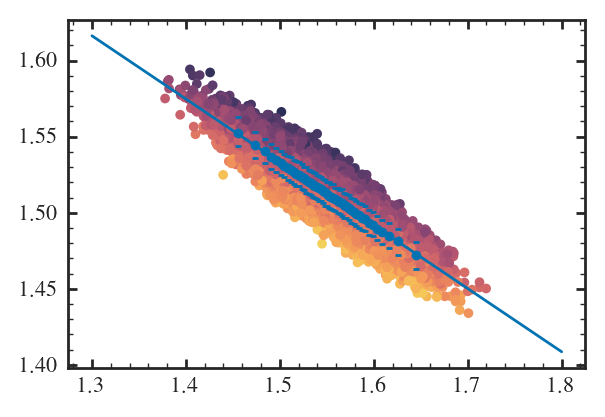

In [155]:
plt.scatter(m.samples.alpha, m.samples.y0_cc, c=m.samples.zeta_cc)

x = np.linspace(1.3, 1.8, 1000)
y = y0 + slope*(x - x0)

plt.plot(x, y)

arya.medianplot(m.samples, x="alpha", y="y0_cc", binsize=1000, )

If total yield is conserved, then y0_cc + alpha * y_agb = y_tot
so the d y0 / d alpha = - y_agb

In [156]:
y_agb = -slope
alpha_0 = x0
y0 = y0
y0 + alpha_0 * y_agb, y_agb

(np.float64(2.1566631954073205), np.float64(0.4156030937723989))

Similarly, is the AGB trend is well-described by a linear trend, then 

$$
(y_{0, cc} + \zeta  (Z-Z0) / Z0) + \alpha * (y_a + \zeta * (Z-Z0)/Z0) = y_{0, tot} + \zeta_{tot} *(Z-Z0) / Z0
$$

The zeta terms seperate out as before, so the d zeta / d alpha = - zeta_agb

In [157]:
x0_z, y0_z, slope_z = fit_lin_trend(m, "alpha", "zeta_cc")
x0_z, y0_z, slope_z

(np.float64(1.5495472467292093),
 np.float64(0.7176338423538292),
 np.float64(0.06050666988973752))

In [158]:
to_log_slope(slope)

np.float64(-0.9569614883225324)

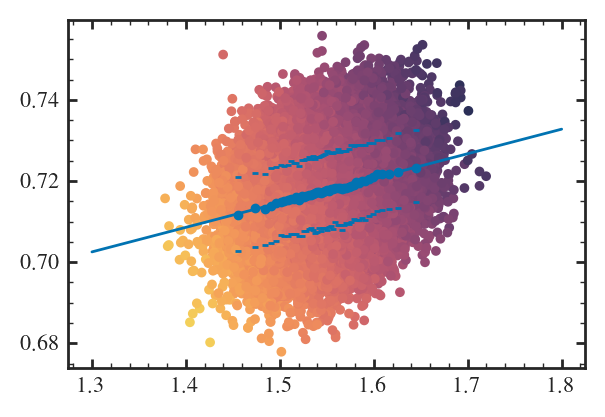

In [159]:
plt.scatter(m.samples.alpha, m.samples.zeta_cc, c=m.samples.y0_cc)

x = np.linspace(1.3, 1.8, 1000)
y = y0_z + slope_z*(x - x0_z)

plt.plot(x, y)

arya.medianplot(m.samples, x="alpha", y="zeta_cc", binsize=1000, )

In [160]:
to_log_slope(0.72)

1.6578612669557131

In [161]:
def make_f_agb_zeta(df, f_new, study="fruity"):
    y0_l = get_df_key(df, "y0_cc")
    slope_l = get_df_key(df, "zeta_cc")
    alpha = get_df_key(df, "alpha")
    y0_s = (y0_l + slope_l) * 1e-3
    
    ya = yagb_props[study]["y0"]
    ytot = ya * alpha + y0_s
    
    f_agb = ya * alpha / ytot
    print("f_agb_old", f_agb)

    alpha_new = f_new * ytot / ya

    y0_new = ytot - alpha_new * ya
    y0_2 = y0 + slope * (alpha_new - x0)
    zeta_new = y0_z + slope_z * (alpha_new - x0_z)
    
    f_new_new = ya * alpha_new / ytot

    print(f"y0 = {y0_new:0.3e}" )
    print(f"y0 = {y0_2:0.3e}" )
    print(f"zeta = {to_log_slope(zeta_new) * 1e-3:0.3e}" )
    print(f"alpha = {alpha_new:0.3f}" )

    print(f"f = {f_new_new:0.3f}" )
    


In [79]:
df = get_params("fiducial_constrained");
print()
make_new_params(df, "fruity")


y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008

alpha_c_agb = 2.72
y0_c_cc = 1.82e-03
zeta_c_cc = 2.08e-03
f = 0.317


In [80]:
make_f_agb_zeta(df, 0.178)

NameError: name 'make_f_agb_zeta' is not defined

In [81]:
make_f_agb_zeta(df, 0.305)

NameError: name 'make_f_agb_zeta' is not defined

In [82]:
make_f_agb_zeta(df, 0.5)

NameError: name 'make_f_agb_zeta' is not defined

In [87]:
df = get_params("fiducial")

for f in [0.1, 0.3, 0.5]: 
    make_f_agb(df, f_new=f, study="fruity")

    print()

y0_cc   	1.513	-0.019	+0.018
alpha   	1.549	-0.040	+0.041
zeta_cc 	0.718	-0.009	+0.009
y0 = 2.441e-03
alpha = 0.872
f = 0.100

y0 = 1.899e-03
alpha = 2.616
f = 0.300

y0 = 1.356e-03
alpha = 4.361
f = 0.500



In [27]:
get_params("fiducial_constrained")

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008


,parameters,median,err_low,err_high,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
0,y0_cc,0.919011,0.009036,0.009101,0.919028,0.009116,0.000059,23625.112548,23329.424964,1.000502,5.397500
1,alpha,2.715042,0.026255,0.026178,2.714989,0.026198,0.000174,22554.974746,23638.535033,1.000343,5.153012
2,zeta_cc,0.901514,0.008253,0.008254,0.901526,0.008357,0.000051,27389.879385,24781.454906,1.000394,6.257616


In [178]:
df = get_params("fiducial_constrained")

for f in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]: 
    make_f_agb(df, f_new=f, study="fruity")

    print()

y0_cc   	0.919	-0.009	+0.009
alpha   	2.715	-0.026	+0.026
zeta_cc 	0.902	-0.008	+0.008
y0 = 2.665e-03
alpha = 0.000
f = 0.000

y0 = 2.398e-03
alpha = 0.857
f = 0.100

y0 = 2.132e-03
alpha = 1.714
f = 0.200

y0 = 1.865e-03
alpha = 2.571
f = 0.300

y0 = 1.599e-03
alpha = 3.428
f = 0.400

y0 = 1.332e-03
alpha = 4.284
f = 0.500

y0 = 1.066e-03
alpha = 5.141
f = 0.600

y0 = 5.330e-04
alpha = 6.855
f = 0.800



In [30]:
def make_mass_shift_alpha(mf=0.5, alpha=2.71):
    ya_new = yagb_props[f"fruity_mf{mf}"]["y0"]
    ya_old = yagb_props[f"fruity"]["y0"]
    return alpha * ya_old / ya_new

In [31]:
make_mass_shift_alpha(0.5)

2.9781272084805654

In [32]:
make_mass_shift_alpha(0.7)

2.3411388888888887

In [33]:
make_mass_shift_alpha(1.5)

2.71

In [58]:
yagb_props["nugrid"]["y0"]

0.000925

In [57]:
vice.yields.agb.settings["c"]  = surp.agb_interpolator.interpolator("c", study="battino19")

surp.yields.calc_y(kind="agb")

0.0009248417861815101

# Body

## Main comparisons

In [18]:
results = {}

In [19]:
results["fiducial"] = load_model("fiducial", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [22]:
results["fiducial_sigma"] = load_model("fiducial_sigma0.05", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [67]:
results["fiducial_constrained"] = load_model("fiducial_constrained", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [58]:
results["fiducial_constrained_sigma"] = load_model("fiducial_constrained_sigma0.05", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [280]:
results["new_fiducial"] = load_model("quadratic_m1", yagb_props["fruity"])

length of samples =  48000


In [146]:
results["quadratic_m0.7"] = load_model("quadratic_m0.7", yagb_props["fruity"])

length of samples =  48000


In [16]:
results["analytic"] = load_model("analytic_quad", yagb_props["analytic"])

length of samples =  48000


In [18]:
results["analytic_all"] = load_model("analytic_all", yagb_props["analytic"])

length of samples =  48000


In [19]:
res_bad = load_model("fiducial_caah_only", yagb_props["fruity"])

length of samples =  160000


In [30]:
results["eta2"] = load_model("eta2", yagb_props["fruity"])

FileNotFoundError: [Errno 2] No such file or directory: '../models/mcmc_models_2d/eta2//params.toml'

In [21]:
results["lateburst"] = load_model("lateburst", yagb_props["fruity"])

length of samples =  48000


In [22]:
results["twoinfall"] = load_model("twoinfall", yagb_props["fruity"])

length of samples =  48000


In [23]:
results["snia_1.2"] = load_model("snia_1.2", yagb_props["fruity"])

length of samples =  48000


In [24]:
results["old_migration"] = load_model("fiducial_old_migration", yagb_props["fruity"])

length of samples =  48000


In [26]:
oob_results = {}

In [27]:
oob_results["mf0.5"] = load_model("fruity_mf0.5", yagb_props["fruity_mf0.5"])

adding  alpha
length of samples =  48000


In [28]:
oob_results["mf0.7"] = load_model("fruity_mf0.7", yagb_props["fruity_mf0.7"])

adding  alpha
length of samples =  48000


In [29]:
oob_results["mf1.5"] = load_model("fruity_mf1.5", yagb_props["fruity_mf1.5"])

adding  alpha
length of samples =  48000


## Agb models

In [23]:
results["fruity"] = load_model("fiducial", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [24]:
results["fruity_sigma"] = load_model("fiducial_sigma0.05", yagb_props["fruity"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [68]:
results["fruity_m0.7"] = load_model("fruity_mf0.7", yagb_props["fruity_mf0.7"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity_mf0.7', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [25]:
results["fruity_m0.7_sigma"] = load_model("fruity_mf0.7_sigma0.05", yagb_props["fruity_mf0.7"])

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity_mf0.7', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [140]:
#results["fruity_lin"] = load_model("fruity_lin", yagb_props["fruity"])

In [27]:
results["aton"] = load_model("aton", yagb_props["aton"])

length of samples =  48000
{'alpha': {'name': 'perturbations/aton', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [26]:
results["aton_sigma"] = load_model("aton_sigma0.05", yagb_props["aton"])

length of samples =  48000
{'alpha': {'name': 'perturbations/aton', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [28]:
results["monash"] = load_model("monash", yagb_props["monash"])

length of samples =  48000
{'alpha': {'name': 'perturbations/monash', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [29]:
results["monash_sigma"] = load_model("monash_sigma0.05", yagb_props["monash"])

length of samples =  48000
{'alpha': {'name': 'perturbations/monash', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [30]:
results["nugrid"] = load_model("nugrid", yagb_props["nugrid"])

length of samples =  48000
{'alpha': {'name': 'perturbations/nugrid', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


In [57]:
results["nugrid_sigma"] = load_model("nugrid_sigma0.05", yagb_props["nugrid"])

length of samples =  48000
{'alpha': {'name': 'perturbations/nugrid', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


## Other analytic

In [36]:
results["analytic_eta2"] = load_model("analytic_eta2", yagb_props["analytic"])

length of samples =  48000


In [37]:
results["analytic_lateburst"] = load_model("analytic_lateburst", yagb_props["analytic"])

length of samples =  48000


In [38]:
results["analytic_twoinfall"] = load_model("analytic_twoinfall_liam", yagb_props["analytic"])

length of samples =  48000


In [39]:
res_bad_analytic = load_model("analytic_caah_only", yagb_props["analytic"])

length of samples =  160000


## OOb AGBS

In [ ]:
oob_results = {}

In [32]:
oob_results["fruity"] = mc_plot_utils.plot_all("fruity_oob", y0=3.229e-4, y_a=3.82e-4, zeta_a=-3.5e-4)

AttributeError: module 'mc_plot_utils' has no attribute 'plot_all'

In [ ]:
oob_results["aton"] = plot_all("aton_oob",  y0=0.285e-4, y_a=1.85e-4, zeta_a=-9.4e-5)

In [ ]:
oob_results["monash"] = plot_all("monash_oob", y0=3.444e-4, y_a=2.8e-4, zeta_a=-10.1e-4)

In [ ]:
oob_results["nugrid"] = plot_all("nugrid_oob",  y0=10.95e-4, y_a=5.9e-4, zeta_a=-5.7e-4)

### mass shifts

## Extra

In [ ]:
results["analytic_lin"] = plot_all("analytic_lin", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
plot_all("analytic_quad_m0.2", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["fruity_mh0.2"] = plot_all("fruity_mh0.2", y0=3.229e-4, y_a=3.8e-4, zeta_a=-3.5e-4)

In [ ]:
y = surp.yield_models.Quadratic_CC(y0=0.25e-3, zeta=1e-3, A=1e-3, Z1=0.016*10**-0.5)

In [ ]:
y(0.016 * 10**-0.0)

In [ ]:
results["fruity_mh0.5"] = plot_all("fruity_mh0.5", y0=3.229e-4, y_a=3.8e-4, zeta_a=-3.5e-4)

In [32]:
res = results["fruity"]

KeyError: 'fruity'

In [ ]:
res.samples[
    (np.percentile(res.samples.alpha, 99.95) > res.samples.alpha) 
    & (res.samples.alpha > np.percentile(res.samples.alpha, 99.85))].median()

In [ ]:
res.samples[
    (np.percentile(res.samples.alpha, 100 - 99.85) > res.samples.alpha) 
    & (res.samples.alpha > np.percentile(res.samples.alpha, 100 - 99.95))].median()

In [ ]:
ana = results["analytic"]

plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.65}, ana.ah, ana.labels, label="mean")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.65}, ana.ah, ana.labels, label="low z1", linestyle="--")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.25}, ana.ah, ana.labels, label="low z2", linestyle="--")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.25}, ana.ah, ana.labels, label="low z1 z2")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.60, "A_cc": 3.0}, ana.ah, ana.labels, label="high z1 z2")
plot_obs_caah(ana, color="black")
arya.Legend(-1, color_only=True)

plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [ ]:
ana = results["analytic"]

plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.50, "A_cc": 2.65}, ana.afe, ana.labels, label="mean")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.36, "A_cc": 2.25}, ana.afe, ana.labels, label="low z1 z2")
plot_sample({"alpha": 0.49, "y0_cc": 2.28, "zeta_cc": 1.60, "A_cc": 3.0}, ana.afe, ana.labels, label="high z1 z2")
plot_obs_caafe(ana, color="black")
arya.Legend(-1, color_only=True)

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

## Surveys

In [ ]:
results["v21"] = plot_all("fiducial_vincenzo21", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["gso"] = plot_all("fiducial_gso", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

In [ ]:
results["galah"] = plot_all("fiducial_galah", y0=1e-3, y_a=1e-3, zeta_a=-1e-3)

## Test Cases

In [ ]:
test_results = {}

In [ ]:
test_results["NUTS"] = plot_all("NUTS", test=True)

In [ ]:
test_results["HMC"] = plot_all("HMC", test=True)

In [ ]:
test_results["RWMH"] = plot_all("RWMH", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["fine_bins"] = plot_all("fine_bins", test=True)

In [ ]:
test_results["superfine_bins"] = plot_all("superfine_bins", test=True)

In [ ]:
test_results["both_sigma"] = plot_all("both_sigma", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["add_rand_scatter"] = plot_all("add_rand_scatter", test=True)

In [ ]:
test_results["equalnum_fine"] = plot_all("equalnum_fine", test=True)

In [ ]:
test_results["equal_num_bins"] = plot_all("equal_num_bins", test=True)

In [ ]:
test_results["t_test"] = plot_all("t_test", test=True)

In [ ]:
test_results["kstest_samples"] = plot_all("ks_test", test=True)

In [ ]:
test_results["2s"] = plot_all("both_sigma", test=True)

# Comparisons

## Main comparions

### Corners

![](plots/figures/mcmc_corner.png)

In [15]:
import arya

In [16]:
arya.style.set_fontsize(8)

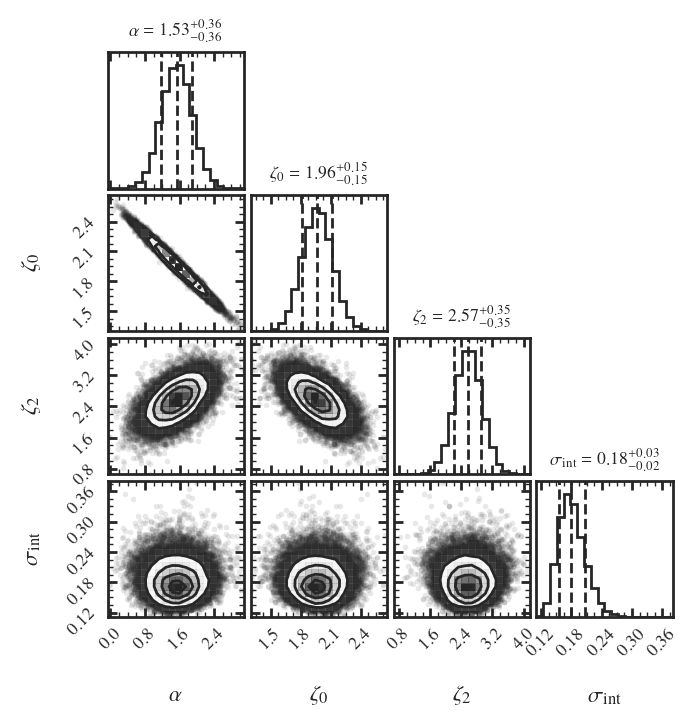

In [19]:
fig = plt.figure(figsize=(3.3, 3.3))

results["new_fiducial"].plot_corner(
            fig = fig,
            labels={
    "alpha": r"$\alpha$",
    "y0_cc": r"$\zeta_0$",
    "A_cc": r"$\zeta_2$",},
            labelpad=0.2,
           )

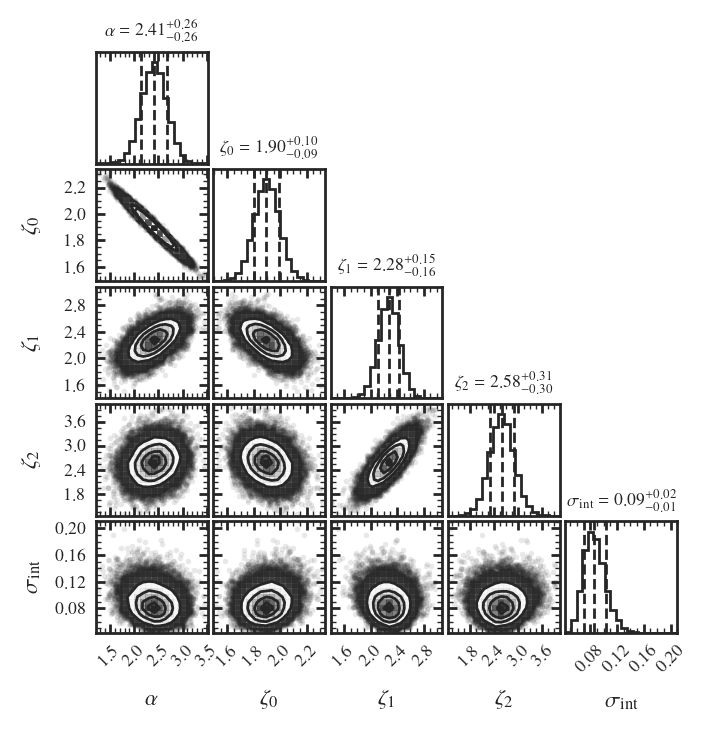

In [33]:
fig = plt.figure(figsize=(3.3, 3.3))

results["fiducial"].plot_corner(
            fig = fig,
            labels={
    "alpha": r"$\alpha$",
    "y0_cc": r"$\zeta_0$",
    "zeta_cc": r"$\zeta_1$",
    "A_cc": r"$\zeta_2$",},
            labelpad=0.2,
           )

for ax in fig.get_axes():
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelrotation=0)

plt.savefig("figures/mcmc_corner.pdf")

In [ ]:
np.mod

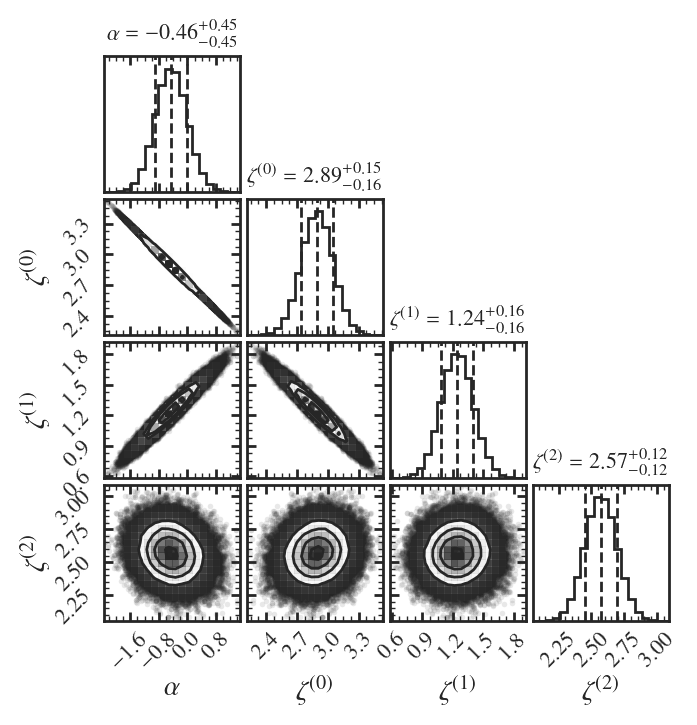

In [174]:
fig = plt.figure(figsize=(3.3, 3.3))

plot_corner(res_bad, 
            fig = fig,
            labels={
    "alpha": r"$\alpha$",
    "y0_cc": r"$\zeta_0$",
    "zeta_cc": r"$\zeta_1$",
    "A_cc": r"$\zeta_2$",},
            labelpad=0.1,
           )

ax = plt.
plt.savefig("figures/mcmc_corner_bad.pdf")

## Total Yields

In [16]:
agb_interpolator = surp.agb_interpolator.interpolator

In [17]:
surp.set_yields(surp.yield_params.YieldParams.from_file("../models/fiducial/best/yield_params.toml"))

In [18]:
def plot_yield(y, **kwargs):
    x = np.linspace(-2, 1, 1000)
    z = gcem.MH_to_Z(x)
    plt.plot(x, np.vectorize(y)(z), **kwargs)

In [19]:
import cc_plot_utils

In [20]:
y_mg = vice.yields.ccsne.settings["mg"]

In [21]:
surp.yield_models.Lin_CC(slope=0.001 / surp.Z_SUN, y0=0)(surp.Z_SUN)

0.0

In [26]:
y_z2 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 2e-3, 1e-3]))


In [33]:
y_z3 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 3e-3, 3e-3, 1e-3]))
y_z4 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 4e-3, 6e-3, 4e-3, 1e-3]))
y_z4 = np.vectorize( surp.yield_models.Polynomial_CC([1e-3, 5e-3, 10e-3, 10e-3, 5e-3, 1e-3]))


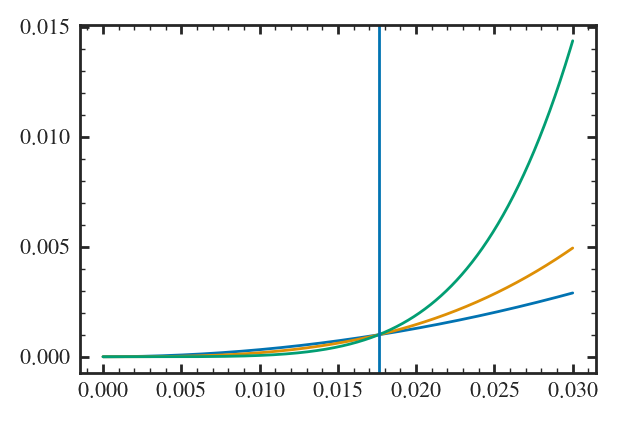

In [34]:

Z = np.linspace(0, 0.03, 1000)

plt.plot(Z, y_z2(Z))
plt.plot(Z, y_z3(Z))
plt.plot(Z, y_z4(Z))

plt.axvline(surp.Z_SUN)

In [40]:
y_z0 = lambda z: 1e-3
y_z1 = np.vectorize(lambda z: 1*y_z0(z) + surp.yield_models.Lin_CC(slope=0.001 / surp.Z_SUN, y0=0)(z))

Y_agbs = {
    "fruity": agb_interpolator("c"),
    "fruity_m0.7": agb_interpolator("c", mass_factor=0.7),
    "aton": agb_interpolator("c", study="ventura13"),
    "monash": agb_interpolator("c", study="karakas16"),
    "nugrid": agb_interpolator("c", study="pignatari16"),
    "analytic": surp.yield_models.C_AGB_Model(y0=1e-3, zeta=1e-3, tau_agb=1, t_D=0.15)
}

In [41]:
mh0 = -1.
y_z1_new = np.vectorize(lambda z: mh0*y_z0(z) + surp.yield_models.BiLogLin_CC(y0=-mh0*0.001, zeta=0.001, y1=0)(z))
y_z2_new = np.vectorize(lambda z: 
                        -mh0**2 * y_z0(z) 
                        + surp.yield_models.Quadratic_CC(y0=0.001 * mh0**2, zeta=-mh0 * 2 * 1e-3, A=0.001, Z1=surp.gce_math.MH_to_Z(mh0))(z))


In [42]:
results["fiducial"].samples

,iteration,chain,y0_cc,alpha,zeta_cc,lp,n_steps,is_accept,acceptance_rate,log_density,...,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size,f_agb,y_tot,f_agb_a,y_tot_a
0,1001,1,1.517523,1.536593,0.716405,-503.619424,31.0,1.0,0.994704,-503.619424,...,-0.012212,-0.030114,4.0,0.0,0.143178,0.143178,0.176222,0.002712,0.272542,0.002086
1,1002,1,1.518406,1.530584,0.718312,-503.674705,15.0,1.0,0.996283,-503.674705,...,-0.007909,-0.017139,3.0,0.0,0.143178,0.143178,0.175473,0.002713,0.271651,0.002085
2,1003,1,1.506736,1.563626,0.719361,-503.617260,31.0,1.0,0.999688,-503.617260,...,-0.000580,-0.011006,5.0,0.0,0.143178,0.143178,0.179284,0.002712,0.277441,0.002085
3,1004,1,1.503114,1.547644,0.728832,-504.344003,23.0,1.0,0.919398,-504.344003,...,0.011954,0.162820,4.0,0.0,0.143178,0.143178,0.177394,0.002713,0.275867,0.002076
4,1005,1,1.512987,1.545107,0.718878,-503.554204,31.0,1.0,0.696766,-503.554204,...,-0.022249,0.796485,4.0,0.0,0.143178,0.143178,0.177160,0.002712,0.274234,0.002085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,3996,16,1.528271,1.507680,0.718386,-504.148454,11.0,1.0,0.900905,-504.148454,...,0.008700,0.198676,3.0,0.0,0.179492,0.179492,0.172668,0.002716,0.267407,0.002086
47996,3997,16,1.528520,1.533439,0.705301,-504.358796,15.0,1.0,0.996192,-504.358796,...,-0.007268,0.018106,4.0,0.0,0.179492,0.179492,0.175931,0.002711,0.270707,0.002096
47997,3998,16,1.514036,1.528602,0.721736,-504.259424,15.0,1.0,0.877221,-504.259424,...,0.230456,0.251556,3.0,0.0,0.179492,0.179492,0.175347,0.002711,0.271965,0.002080
47998,3999,16,1.504006,1.552687,0.725929,-503.949448,23.0,1.0,0.998599,-503.949448,...,-0.227760,-0.234385,4.0,0.0,0.179492,0.179492,0.178001,0.002713,0.276398,0.002079


In [23]:
M_H=np.linspace(-0.5, 0.5, 1000)
Z = gcem.MH_to_Z(M_H)
surp.set_yields(verbose=False)
ys_fiducial = surp.yields.calc_y(Z)

Z = gcem.MH_to_Z(M_H)
y_agbs = {}
for key, Y_agb in Y_agbs.items():
    print(Y_agb)
    vice.yields.agb.settings["c"] = Y_agb
    ys_a = surp.yields.calc_y(Z, kind="agb")
    
    y_agbs[key] = ys_a


NameError: name 'Y_agbs' is not defined

In [44]:
import mc_plot_utils

In [45]:
def plot_y_tot_mean(result, ys_a, M_H=M_H, y_z0=y_z0 , y_z1=y_z1,  **kwargs):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    sample = samples.median()
    yt = sample.y0_cc * ys_z0 + sample.alpha * ys_a
    if "zeta_cc" in sample.keys():
        yt += sample.zeta_cc * ys_z1
    if "A_cc" in sample.keys():
        yt += sample.A_cc * ys_z2 
        
    plt.plot(M_H, yt / ymg, **kwargs)


In [46]:
results["fiducial"].samples.median()

iteration                       2500.500000
chain                              8.500000
y0_cc                              1.512815
alpha                              1.549282
zeta_cc                            0.717656
lp                              -504.685333
n_steps                           15.000000
is_accept                          1.000000
acceptance_rate                    0.929961
log_density                     -504.685333
hamiltonian_energy               506.175995
hamiltonian_energy_error           0.000000
max_hamiltonian_energy_error       0.125202
tree_depth                         4.000000
numerical_error                    0.000000
step_size                          0.172984
nom_step_size                      0.172984
f_agb                              0.177650
y_tot                              0.002712
f_agb_a                            0.274768
y_tot_a                            0.002086
dtype: float64

In [47]:
def plot_y_tot(result, ys_a, thin=10, M_H=M_H, color="black", alpha=None):
    samples = result.samples
    Z = gcem.MH_to_Z(M_H)
    if alpha is None:
        alpha = 1 / len(samples)**(1/3) / 10
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    for i, sample in samples[::thin].iterrows():
        yt = sample.y0_cc * ys_z0 + sample.zeta_cc * ys_z1 + sample.alpha * ys_a
        plt.plot(M_H, yt / ymg, color=color, alpha=alpha, rasterized=True)
    





In [73]:
def plot_ana(y0, slope, **kwargs):
    x = np.linspace(-1, 0.5, 1000)
    Z = gcem.MH_to_Z(x)

    y_model = np.vectorize(surp.yield_models.Lin_CC(slope = slope / surp.Z_SUN, y0=y0))

    y = y_model(Z)

    plt.plot(x, y / y_mg, **kwargs)

In [121]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
   # "analytic": r"analytic",    
    "fiducial_constrained": r"FRUITY + gas",

    "fruity_m0.7": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
}

warning, no agb for  fiducial_constrained


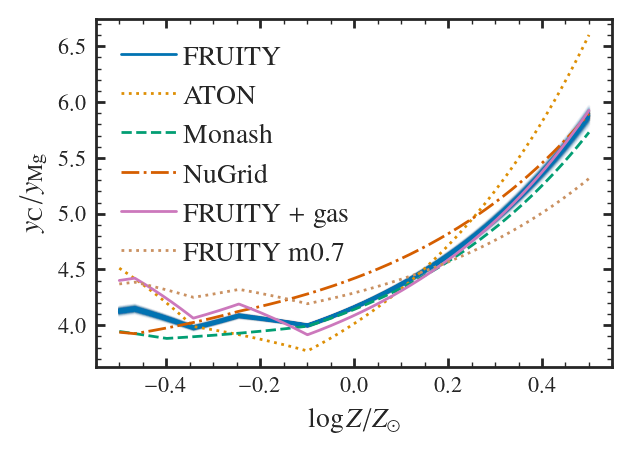

In [122]:

plt.figure()
plot_y_tot(results["fiducial"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

# plot_ana(2.7e-3, 0.35e-3, color="black")
# plot_ana(3.1e-3, 0.35e-3, color="black")

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.legend()
plt.savefig("figures/mcmc_y_tot.pdf")

In [123]:
plot_labels = {
    "fruity_sigma": r"FRUITY",
    "aton_sigma": r"ATON",
    "monash_sigma": r"Monash",
    "nugrid_sigma": r"NuGrid",
   # "analytic": r"analytic",
    "fiducial_constrained_sigma": r"FRUITY + gas",
    "fruity_m0.7_sigma": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
}

warning, no agb for  fiducial_constrained_sigma


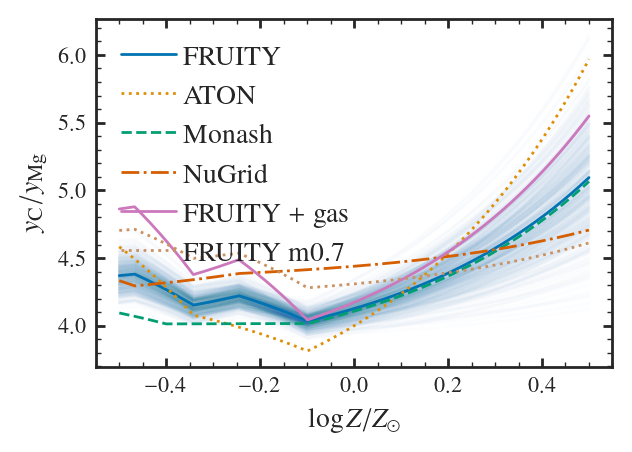

In [124]:
plt.figure()
plot_y_tot(results["fiducial_sigma"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    elif key.split("_sigma")[0] in y_agbs.keys():
        y_agb = y_agbs[key.split("_sigma")[0]]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.legend()
plt.savefig("figures/mcmc_y_tot.pdf")

In [ ]:
y0 = vice.yields.ccsne.settings["c"]

plot_yield(1/y_mg * y0)
plot_y_tot_mean(results["fiducial"], 0)


In [ ]:
plot_labels = {
    "fiducial": r"fiducial",
    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
}

In [ ]:

plt.figure()
plot_y_tot(results["fruity"], y_agbs["fruity"], thin=100, alpha=0.01, color=arya.COLORS[0])

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]

    
    plot_y_tot_mean(result, y_agb, color=arya.COLORS[i], label=label, ls=["-", ":", "--", "-."][i%4])
    

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C}$")

plt.legend()


In [ ]:
plot_labels = {
    "fiducial": r"fiducial",
    "new_fiducial": r"new",
}

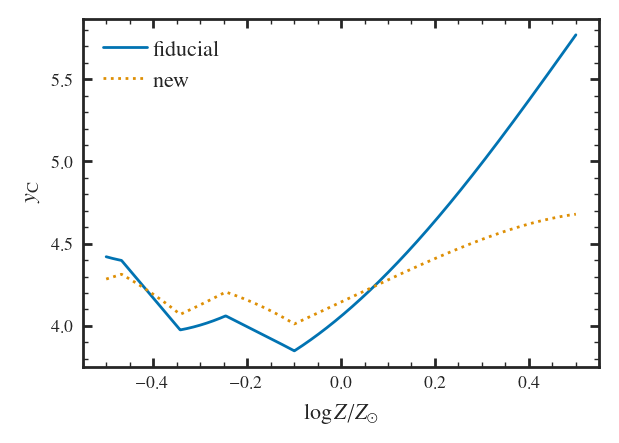

In [281]:

plt.figure()

    
plot_y_tot_mean(results["fiducial"], y_agbs["fruity"], color=arya.COLORS[0], label="fiducial", ls=["-", ":", "--", "-."][0])
plot_y_tot_mean(results["new_fiducial"], y_agbs["fruity"], color=arya.COLORS[1], y_z2=y_z2_new, label="new", ls=["-", ":", "--", "-."][1])
    

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C}$")

plt.legend()


In [269]:
results["new_fiducial"].print_stats()

parameter	 med	 16th	 84th	0.1th	99.9th
alpha   	 2.187	-0.370	+0.354	-1.256	+1.140
y0_cc   	 1.634	-0.157	+0.164	-0.503	+0.559
A_cc    	 0.762	-0.091	+0.086	-0.316	+0.276
sigma_int	 0.151	-0.022	+0.028	-0.058	+0.108


In [270]:
y_z1_new(gcem.MH_to_Z(0.3))

array(0.0003)

In [275]:
y0 = 1.63
zeta = 0.08#0.66
A = 0.76

mh0 = -1.0

zeta1 = zeta - 2*mh0  * A
y1 = y0 - 0*zeta*mh0 #- A*mh0**2

print(f"y1 \t {y1:0.3f}e-3")
print(f"zeta1 \t {zeta1:0.3f}e-3")

print(f"A \t {A:0.3f}e-3")

y_cc_new = surp.yield_models.Quadratic_CC(A=A, y0=y1, zeta=zeta1, Z1=gcem.MH_to_Z(mh0))

def y_new_2(Z):
    return A*y_z2_new(Z) + zeta*y_z1_new(Z) + y0 * y_z0(Z)

y1 	 1.630e-3
zeta1 	 1.600e-3
A 	 0.760e-3


In [276]:
gcem.MH_to_Z(mh0)

np.float64(0.0017600000000000003)

In [277]:
yp = surp.YieldParams.from_file("../models/new_fiducial/run/yield_params.toml")
surp.set_yields(yp)

yc3 = vice.yields.ccsne.settings["c"]

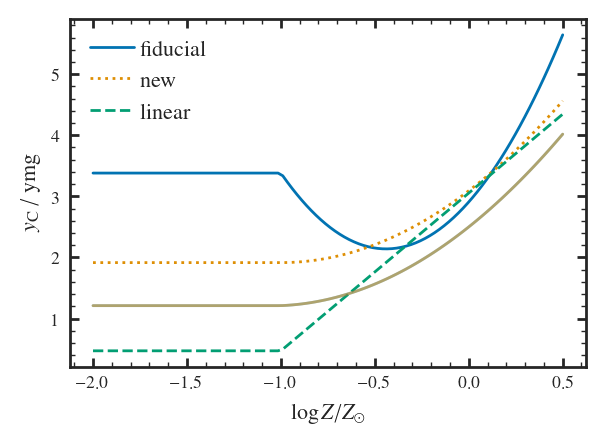

In [282]:

y_mg = vice.yields.ccsne.settings["mg"]
plt.figure()

    
plot_y_tot_mean(results["fiducial"],  0, color=arya.COLORS[0], label="fiducial", ls=["-", ":", "--", "-."][0], M_H=np.linspace(-2, 0.5, 100))
plot_y_tot_mean(results["new_fiducial"], 0, y_z1=y_z1_new, y_z2=y_z2_new, color=arya.COLORS[1], label="new", ls=["-", ":", "--", "-."][1], M_H=np.linspace(-2, 0.5, 100))
plot_y_tot_mean(results["fruity_lin"], 0, color=arya.COLORS[2], label="linear", ls=["-", ":", "--", "-."][2], M_H=np.linspace(-2, 0.5, 100))

x = np.linspace(-2, 0.5, 100)
y = np.vectorize(y_cc_new)(gcem.MH_to_Z(x)) * 1e-3 / y_mg
plt.plot(x, y, alpha=0.5)

y = np.vectorize(y_new_2)(gcem.MH_to_Z(x))  / y_mg
plt.plot(x, y, alpha=0.5)



plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C}$ / ymg")

plt.legend()


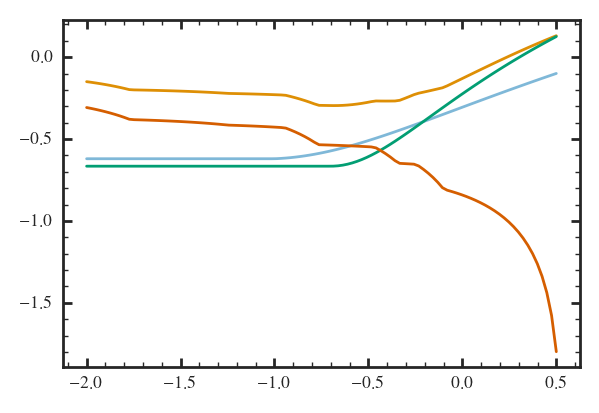

In [279]:
x = np.linspace(-2, 0.5, 100)
y = np.vectorize(y_cc_new)(gcem.MH_to_Z(x)) * 1e-3 / y_mg
plt.plot(x, gcem.abund_ratio_to_brak(y, "c", "mg"), alpha=0.5)

plt.plot(x, gcem.abund_ratio_to_brak(surp.yields.calc_y(gcem.MH_to_Z(x)) / y_mg, "c", "mg"))
plt.plot(x, gcem.abund_ratio_to_brak(surp.yields.calc_y(gcem.MH_to_Z(x), kind="ccsne") / y_mg, "c", "mg"))
plt.plot(x, gcem.abund_ratio_to_brak(surp.yields.calc_y(gcem.MH_to_Z(x), kind="agb") / y_mg, "c", "mg"))


In [194]:
gcem.abund_ratio_to_brak(1.3, "c", "mg")

np.float64(-0.5895338257272533)

KeyError: 'new_fiducial'

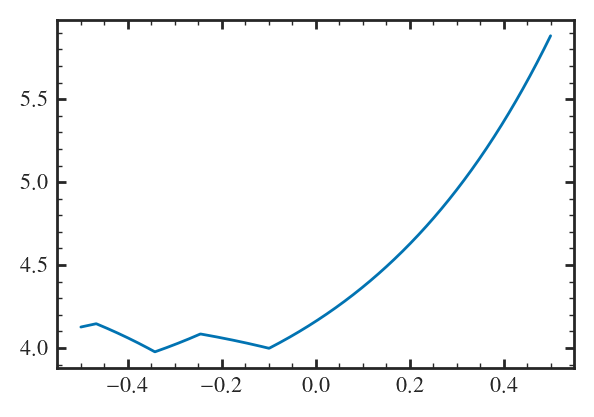

In [69]:

plt.figure()

    
plot_y_tot_mean(results["fiducial"],  y_agbs["fruity"], color=arya.COLORS[0], label="fiducial", ls=["-", ":", "--", "-."][0])
plot_y_tot_mean(results["new_fiducial"], y_agbs["fruity"], y_z1=y_z1_new, y_z2=y_z2_new, color=arya.COLORS[1], label="new", ls=["-", ":", "--", "-."][1])
plot_y_tot_mean(results["fruity_lin"], y_agbs["fruity"], color=arya.COLORS[2], label="linear", ls=["-", ":", "--", "-."][2])


plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylabel(r"$y_{\rm C}$ / ymg")

plt.legend()


In [227]:
0.8e-3 / vice.yields.ccsne.settings["mg"]

1.2269938650306749

In [19]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 6), sharex="col", sharey=True, gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()): 
    result = results[key]
    plt.sca(axs[i])
    if key in y_agbs.keys():
        y_agb = y_agbs[key]
    else:
        print("warning, no agb for ", key)
        
        y_agb = y_agbs["fruity"]
        
    plot_y_tot(result, y_agb, thin=100, alpha=0.01)
    
    plt.ylabel(label)

fig.supylabel(r"$y_{\rm C} / y_{\rm Mg}$")

plt.xlabel(r"$\log Z / Z_\odot$")
plt.ylim(3, 8)
plt.tight_layout()


NameError: name 'plot_labels' is not defined

In [112]:
def compare_param_hists(results, plot_labels, var):
    Nr = len(plot_labels)
    fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})
    
    for i, (key, label) in enumerate(plot_labels.items()):
        if key == "hline":
            ax = axs[i]
            plt.sca(axs[i])
            ax.spines[['bottom', 'top']].set_visible(False)
            plt.axhline(0.5, color=label, linestyle=":")
            ax.xaxis.set_visible(False)
            ax.set_yticks([])
            ax.set_yticks([], minor=True)
            
            continue
    
        color = arya.COLORS[i]
        
        result = results[key]
        ax = axs[i]
        plt.sca(axs[i])
        ls = "-"
        plt.hist(result.samples[var], histtype="step", color=color, ls=ls)
        plt.ylabel(label, rotation=0, ha="right", va="center")
        
        if Nr - 1 > i > 0:
            ax.spines[['bottom', 'top']].set_visible(False)
            ax.xaxis.set_visible(False)
        elif i == 0:
            ax.spines[['bottom']].set_visible(False)
            ax.tick_params(axis='x',  bottom=False, which="both")
        elif i == Nr - 1:
            ax.spines[['top']].set_visible(False)
            ax.tick_params(axis='x',  top=False, which="both")
    
    
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
    
    
    
    plt.sca(axs[-1])
    plt.xlabel(var)

In [130]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": r"FRUITY m0.7",
    "fiducial_constrained": r"FRUITY+gas-phase",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

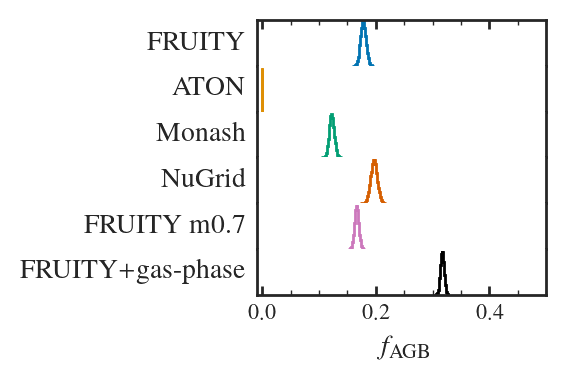

In [131]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i == -1:
        color = arya.COLORS[0]
        ls = "--"
    elif i < 5:
        color = arya.COLORS[i]
        ls = "-"
    elif i == 5:
        ls = "-"
        color = "k"
    else:
        ls = "--"
        color = "k"

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb, histtype="step", color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")
    
    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(-0.01, 0.5)

plt.tight_layout()


In [127]:
plot_labels = {
    "fruity_sigma": r"FRUITY",
    "aton_sigma": r"ATON",
    "monash_sigma": r"Monash",
    "nugrid_sigma": r"NuGrid",
    "fruity_m0.7_sigma": r"FRUITY m0.7",
    "fiducial_constrained_sigma": r"FRUITY+gas-phase",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

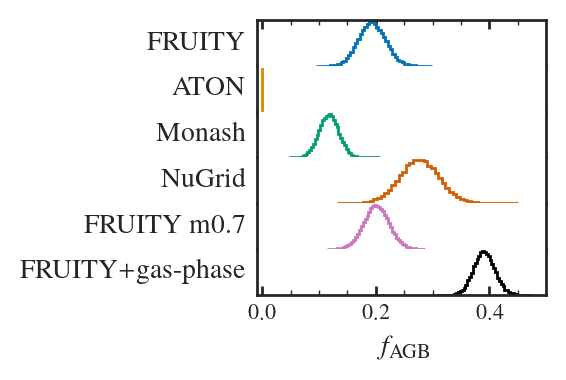

In [128]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i == -1:
        color = arya.COLORS[0]
        ls = "--"
    elif i < 5:
        color = arya.COLORS[i]
        ls = "-"
    elif i == 5:
        ls = "-"
        color = "k"
    else:
        ls = "--"
        color = "k"

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb, histtype="step", color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")
    
    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(-0.01, 0.5)

plt.tight_layout()


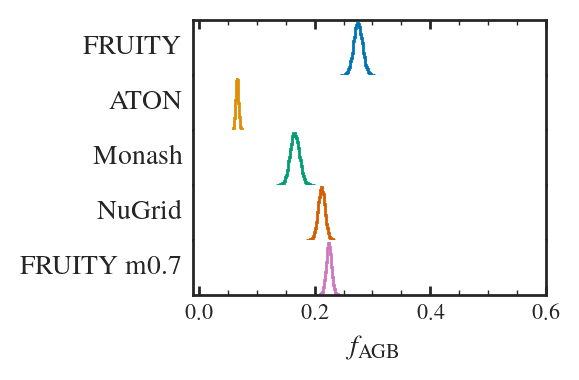

In [113]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i == -1:
        color = arya.COLORS[0]
        ls = "--"
    elif i < 5:
        color = arya.COLORS[i]
        ls = "-"
    elif i == 5:
        ls = "-"
        color = "k"
    else:
        ls = "--"
        color = "k"

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb_a, histtype="step", color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")
    
    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(-0.01, 0.6)

plt.tight_layout()


In [152]:
results["fiducial_constrained"]

KeyError: 'fiducial_constrained'

In [109]:
def plot_all_params(plot_labels):
    for param in ["f_agb", "y0_cc", "zeta_cc", "y_tot"]:
        compare_param_hists(results, plot_labels,  param)
        plt.show()

In [110]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": r"FRUITY m0.7",

    # "eta2": r"$y\rightarrow 2y$",
    # "lateburst": r"lateburst",
    # "twoinfall": r"twoinfall",
    # "snia_1.2": r"SNIa 1.2x",
}

In [111]:
plot_all_params(plot_labels)

NameError: name 'compare_param_hists' is not defined

f =  0.13261648745519716  key,  fruity
f =  0.03584229390681004  key,  aton
f =  0.08243727598566308  key,  monash
f =  0.29032258064516125  key,  nugrid
f =  0.15053763440860216  key,  fruity_m0.7
warning, eta2 not found
f =  0.13261648745519716  key,  eta2


/tmp/ipykernel_2255385/3941882599.py:39: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(f0, 0, c="black", edgecolors="black", lw=1, marker="x")
/tmp/ipykernel_2255385/3941882599.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(f0, 0, c=color, edgecolors="black", lw=0.5, marker="x")


warning, lateburst not found
f =  0.13261648745519716  key,  lateburst
warning, twoinfall not found
f =  0.13261648745519716  key,  twoinfall
warning, snia_1.2 not found
f =  0.13261648745519716  key,  snia_1.2


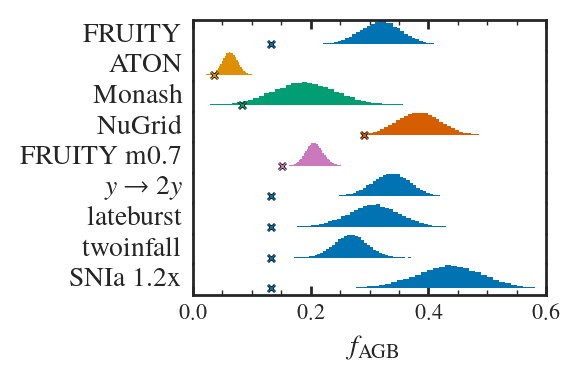

In [210]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 1, figsize=(3, 2), sharex="col", gridspec_kw={"hspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    if key == "hline":
        ax = axs[i]
        plt.sca(axs[i])
        ax.spines[['bottom', 'top']].set_visible(False)
        plt.axhline(0.5, color=label, linestyle=":")
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)
        
        continue

    if i < 5:
        color = arya.COLORS[i]
        ls = "-"
    else:
        ls = "--"
        color = arya.COLORS[0]

    result = results[key]
    ax = axs[i]
    plt.sca(axs[i])
    plt.hist(result.samples.f_agb_a, color=color, ls=ls)
    plt.ylabel(label, rotation=0, ha="right", va="center")

    if key in yagb_props.keys():
        y_a = yagb_props[key]["y_a"]
    elif key == "fruity_m0.7":
        y_a = yagb_props["fruity_mf0.7"]["y_a"]
    else:
        print(f"warning, {key} not found")
        y_a = yagb_props["fruity"]["y_a"]

    f0 = y_a / 2.79e-3
    print("f = ", f0, " key, ", key)
    plt.scatter(f0, 0, c="black", edgecolors="black", lw=1, marker="x")
    plt.scatter(f0, 0, c=color, edgecolors="black", lw=0.5, marker="x")

    if Nr - 1 > i > 0:
        ax.spines[['bottom', 'top']].set_visible(False)
        ax.xaxis.set_visible(False)
    elif i == 0:
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(axis='x',  bottom=False, which="both")
    elif i == Nr - 1:
        ax.spines[['top']].set_visible(False)
        ax.tick_params(axis='x',  top=False, which="both")


    ax.set_yticks([])
    ax.set_yticks([], minor=True)
    plt.ylim(-1000)



plt.sca(axs[-1])
plt.xlabel(r"$f_{\rm AGB}$")
plt.xlim(0, 0.6)

plt.tight_layout()
plt.savefig("figures/mcmc_fagb.pdf")

In [25]:
plot_labels = {
    "fiducial": r"FRUITY",
    "new_fiducial": r"new",
}

In [35]:
results["new_fiducial"]

MCMCResult(params={'alpha': {'name': 'fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'const_cc', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'linear_m0.7', 'y_shift': -0.7, 'prior': 'TruncNormal', 'prior_args': [0.0, 2.0, 0.0, inf]}, 'A_cc': {'name': 'quadratic_m0.7', 'prior': 'Normal', 'prior_args': [0.0, 4.0]}}, labels=['alpha', 'y0_cc', 'zeta_cc', 'A_cc'], all_labels=['alpha', 'y0_cc', 'zeta_cc', 'A_cc'], samples=       iteration  chain     y0_cc      A_cc     alpha   zeta_cc  sigma_int  \
0           1001      1  1.992092  2.989691  2.104855  2.264836   0.095431   
1           1002      1  1.990159  3.036279  2.112378  2.313226   0.090787   
2           1003      1  1.823096  2.718319  2.636907  2.338162   0.068293   
3           1004      1  1.837032  2.691742  2.580916  2.377063   0.066292   
4           1005      1  1.878854  2.476751  2.495753  2.227821   0.100253   
...          ...    ...       ...       ...       ...       ... 

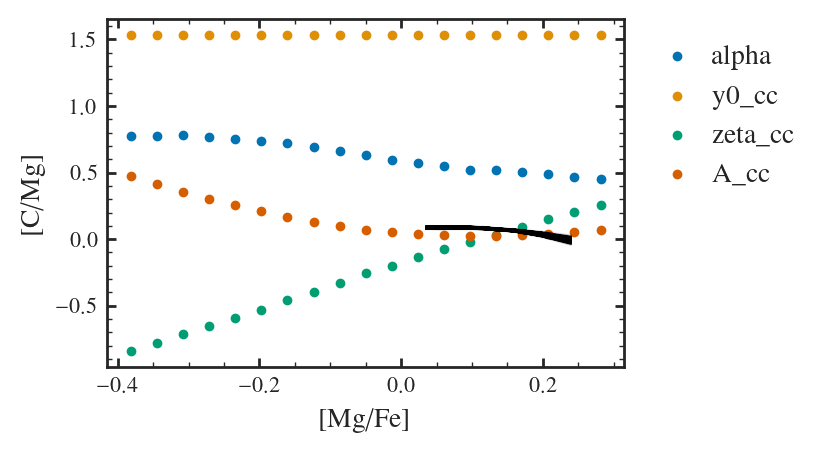

In [39]:
mc_plot_utils.plot_yields(results["new_fiducial"])


In [34]:
results["fiducial"]

MCMCResult(params={'alpha': {'name': 'fiducial', 'C_MG': 'AG_MG', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'fiducial', 'C_MG': 'CD_MG', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'fiducial', 'C_MG': 'IN_MG', 'y_shift': -1, 'prior': 'Normal', 'prior_args': [0.0, 2.0]}, 'A_cc': {'name': 'fiducial', 'prior': 'Normal', 'prior_args': [0.0, 4.0], 'C_MG': 'SN_MG'}}, labels=['alpha', 'y0_cc', 'zeta_cc', 'A_cc'], all_labels=['alpha', 'y0_cc', 'zeta_cc', 'A_cc'], samples=       iteration  chain     y0_cc      A_cc     alpha   zeta_cc  sigma_int  \
0           1001      1  2.146563  2.515566  1.661317  2.059702   0.154134   
1           1002      1  2.125158  2.378730  1.804558  2.052989   0.134253   
2           1003      1  1.885626  2.557980  2.429035  2.229780   0.116069   
3           1004      1  1.889027  2.543317  2.442069  2.236792   0.117039   
4           1005      1  2.037326  2.781596  2.028482  2.274663   0.069166   
...          ...    

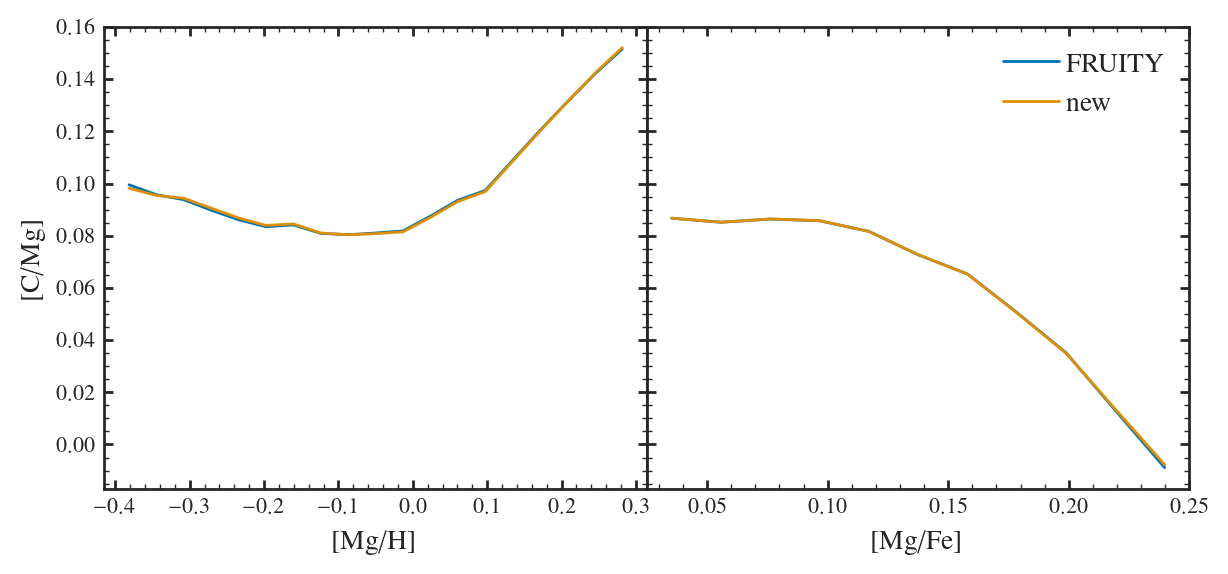

In [28]:

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
for i, (key, label) in enumerate(plot_labels.items()):
    mc_plot_utils.plot_samples_caah_mean(results[key], label=label, color=arya.COLORS[i])


plt.sca(axs[1])

for key, label in plot_labels.items():
    mc_plot_utils.plot_samples_caafe_mean(results[key], label=label)
plt.ylabel("")
plt.legend()


In [103]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": "FRUITY m0.7",
}

NameError: name 'results' is not defined

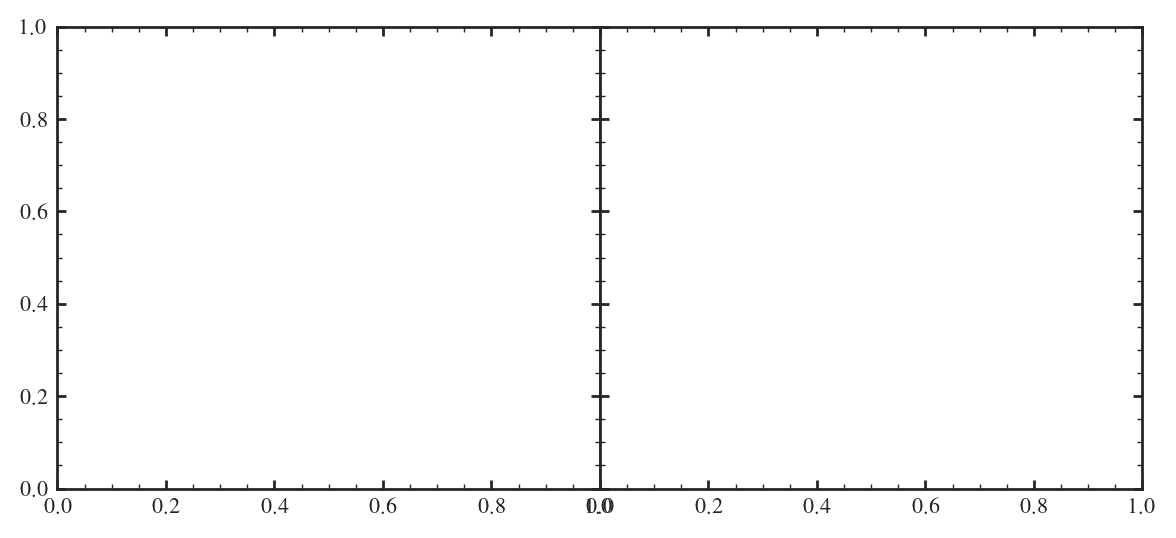

In [94]:

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
mc_plot_utils.plot_samples_caah(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
for i, (key, label) in enumerate(plot_labels.items()):
    mc_plot_utils.plot_samples_caah_mean(results[key], label=label, color=arya.COLORS[i])


mc_plot_utils.plot_obs_caah(results["analytic"], color="black")


plt.sca(axs[1])
mc_plot_utils.plot_samples_caafe(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)

for key, label in plot_labels.items():
    mc_plot_utils.plot_samples_caafe_mean(results[key], label=label)
mc_plot_utils.plot_obs_caafe(results["analytic"], color="k")
plt.ylabel("")
plt.legend()


In [133]:
import mw_model_plots

Text(0, 0.5, '')

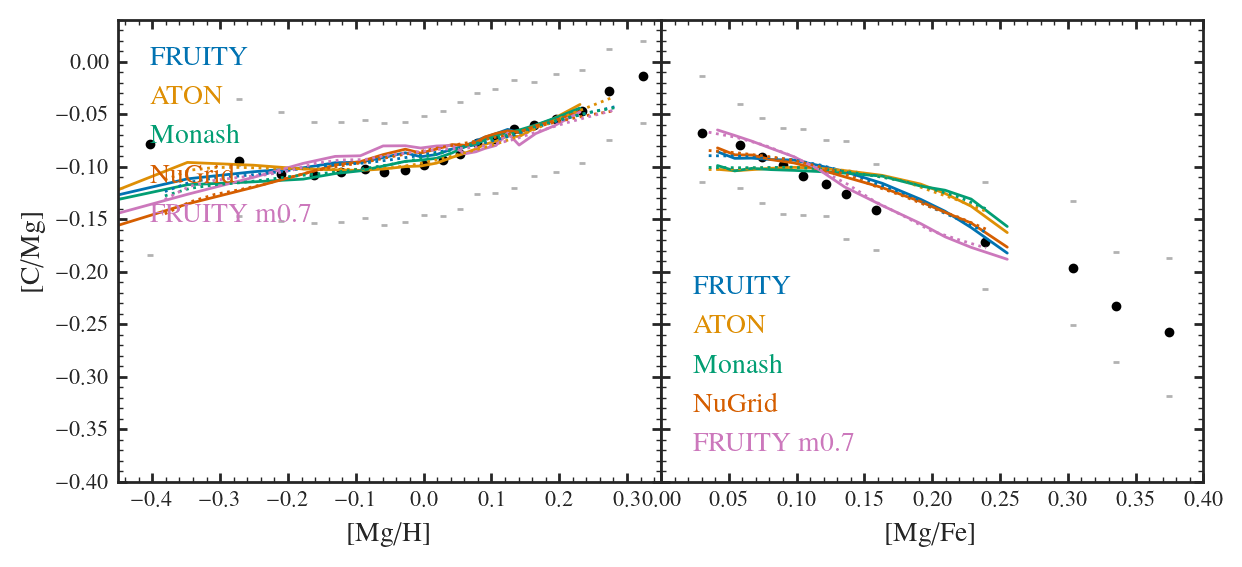

In [135]:
plot_labels = {
    "fruity": r"FRUITY",
    "aton": r"ATON",
    "monash": r"Monash",
    "nugrid": r"NuGrid",
    "fruity_m0.7": "FRUITY m0.7"
}

names = [    
    "fiducial/best",
    "aton/run",
    "monash/run",
    "nugrid/run",
    "fruity/agb_mass_0.7_alpha/",

  # "analytic/mc_best",
  ]

labels = ["FRUITY", "ATON", "Monash",  "NuGrid", "FRUITY m0.7"]




fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])

mw_model_plots.compare_cooh(names, labels)

for i, (key, label) in enumerate(plot_labels.items()):
    mc_plot_utils.plot_samples_caah_mean(results[key], color=arya.COLORS[i], linestyle=":")



plt.sca(axs[1])
mw_model_plots.compare_coofe(names, labels)
for key, label in plot_labels.items():
    mc_plot_utils.plot_samples_caafe_mean(results[key],linestyle=":")


plt.ylabel("")


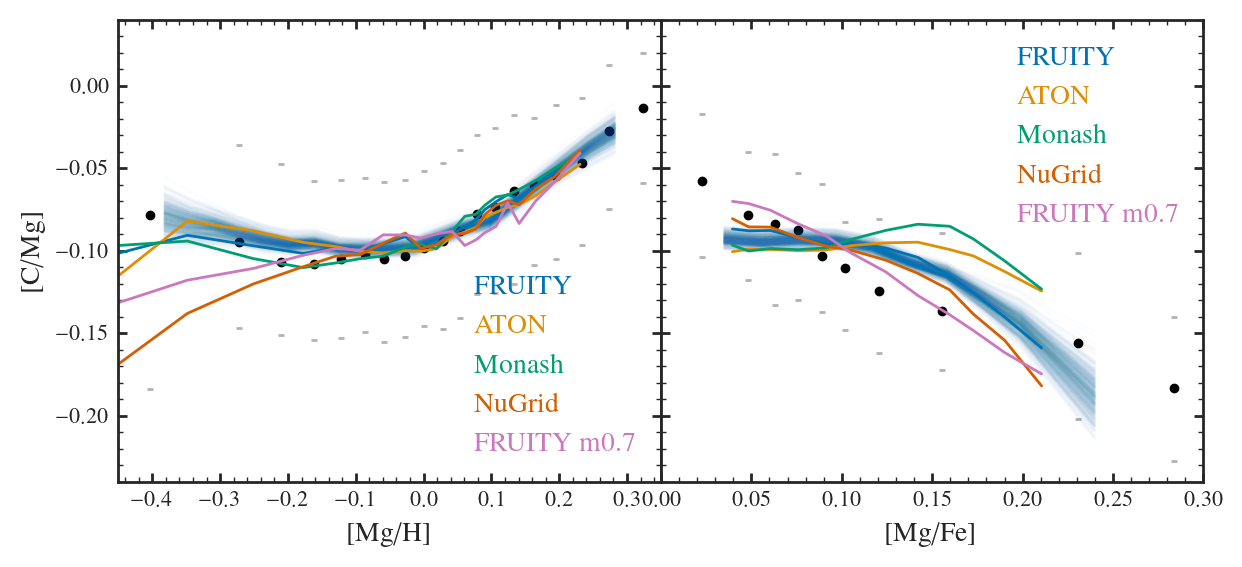

In [117]:
names = [    
    "fiducial/run",
    "aton/best",
    "monash/best",
    "nugrid/best",
    "fruity/agb_mass_0.7_alpha/",
  # "analytic/mc_best",
  ]

labels = ["FRUITY", "ATON", "Monash",  "NuGrid", "FRUITY m0.7"]




fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
mc_plot_utils.plot_samples_caah(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
mw_model_plots.compare_cooh(names, labels)


plt.sca(axs[1])
mc_plot_utils.plot_samples_caafe(results["fruity"], color=arya.COLORS[0], alpha=0.01, skip=100)
mw_model_plots.compare_coofe(names, labels)

plt.ylabel("")
plt.savefig("figures/mcmc_caahfe_predicted.pdf")

## Tabulated properties

In [136]:
def calc_χ2(result, median=False, normalized=False, verbose=False, generous=False):

    if median:
        samples = result.samples.median()
    else:
        samples = result.samples
        
    chi2_ah = calc_χ2_binned(result.ah, samples, result.labels, generous=generous)
    chi2_afe = calc_χ2_binned(result.afe, samples, result.labels, generous=generous)

    df = (len(result.ah) + len(result.afe)) - len(result.labels)


    if verbose:
        print("df", df)
        print("ah", chi2_ah)
        print("afe", chi2_afe)
        
    if normalized:
        return (chi2_ah + chi2_afe) / df
    else:

        return (chi2_ah + chi2_afe) 


In [137]:
def calc_χ2_binned(binned_data, samples, labels, generous = True):

    y_exp = binned_data.obs
    sigma2_exp = binned_data.obs_err**2 / (binned_data.obs_counts)

    χ2 = 0
    for i in range(len(y_exp)):
        y_tot = np.sum([binned_data[label][i] * samples[label] for label in labels], axis=0)
        sigma2_err = np.sum([binned_data[f"{label}_err"][i]**2 * samples[label] / binned_data["_counts"][i] for label in labels], axis=0)

        if generous:
            sigma_int = np.median(samples.sigma_int)
        else:
            sigma_int = 0
            
        χ2 += (y_exp[i] - y_tot)**2  / (sigma2_exp[i] + sigma2_err + sigma_int ** 2)
    
    return  χ2
    

In [138]:
calc_χ2(results["fiducial"], median=True)

np.float64(314.5979498050405)

df 27
ah 195.49020881405727
afe 119.10774099098326
fiducial
fiducial 	 -505.82011243841043 	 11.651775918705205

df 27
ah 536.5056755701523
afe 338.0097823924222
fiducial_sigma
fiducial_sigma 	 -51.48903664442319 	 32.38946140602128

df 27
ah 195.49020881405727
afe 119.10774099098326
fruity
fruity 	 -505.82011243841043 	 11.651775918705205

df 27
ah 536.5056755701523
afe 338.0097823924222
fruity_sigma
fruity_sigma 	 -51.48903664442319 	 32.38946140602128

df 27
ah 739.2997841135052
afe 257.4652433554755
fruity_m0.7_sigma
fruity_m0.7_sigma 	 -47.07409098799489 	 36.91722323959188

df 27
ah 206.37110241309273
afe 330.66882589137504
aton_sigma
aton_sigma 	 -56.29721730855321 	 19.89036771498029

df 27
ah 97.04531228311016
afe 236.86773716947562
aton
aton 	 -493.8114421138058 	 12.367149979725399

df 27
ah 224.6349869538157
afe 234.33516869704727
monash
monash 	 -765.5834592200451 	 16.998894653735665

df 27
ah 332.1045528900871
afe 353.87028953480154
monash_sigma
monash_sigma 	 -62.271300

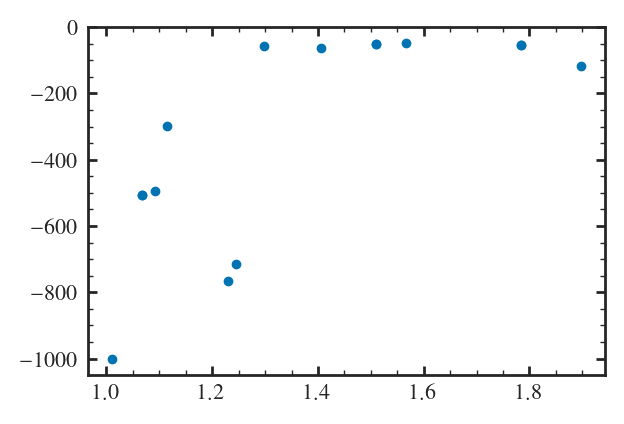

In [139]:

chi2s = []
lps = []
for label, result in results.items():
    χ2 = calc_χ2(result, median=True, normalized=True, verbose=True)
    lp = np.quantile(result.samples.lp, 0.2)
    chi2s.append(χ2)
    lps.append(lp)
    if lp < 0:
        print(label)
    print(label, "\t", lp, "\t", χ2)
    print()

plt.scatter(np.log10(chi2s), np.array(lps))


fiducial           11.65    11.70 -    0.22 +    0.24
fiducial_sigma     32.39    36.20 -   10.58 +   14.33
fruity             11.65    11.70 -    0.22 +    0.24
fruity_sigma       32.39    36.20 -   10.58 +   14.33
fruity_m0.7_sigma   36.92    40.99 -   12.30 +   15.69
aton_sigma         19.89    22.56 -    6.10 +   10.96
aton               12.37    12.41 -    0.28 +    0.34
monash             17.00    17.03 -    0.31 +    0.37
monash_sigma       25.41    28.15 -    6.48 +   10.97
nugrid             17.58    17.62 -    0.12 +    0.17
nugrid_sigma0.05   60.74    65.20 -   18.42 +   23.13
nugrid_sigma       60.74    65.20 -   18.42 +   23.13
fiducial_constrained_sigma   79.05    81.36 -   22.04 +   27.29
fiducial_constrained   10.23    10.25 -    0.48 +    0.56
fruity_m0.7        13.02    13.06 -    0.45 +    0.51


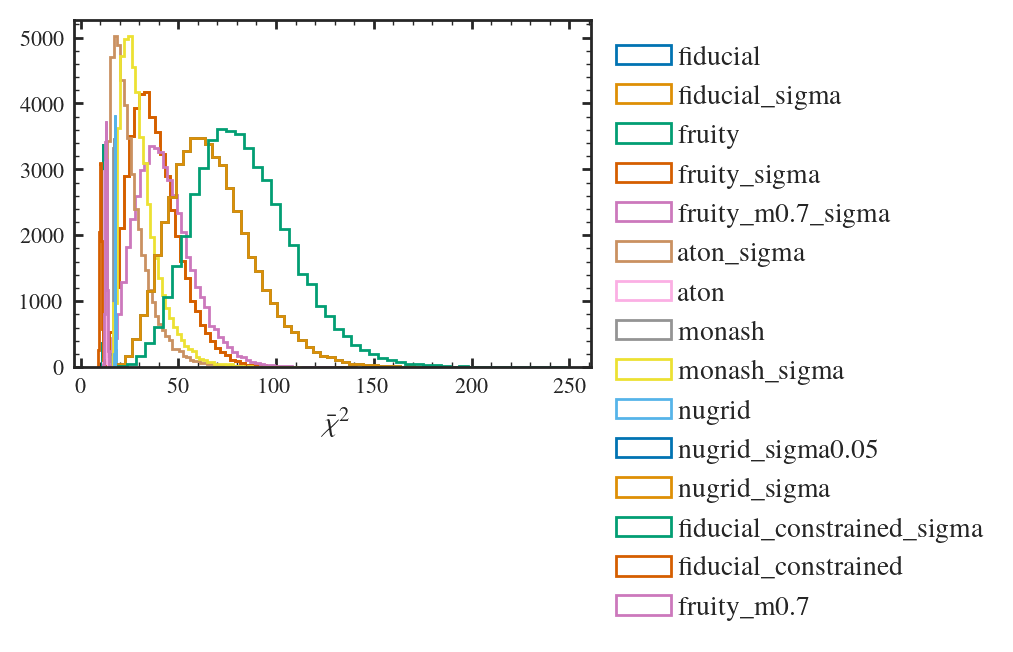

In [140]:

for label, result in results.items():
    χ2 = calc_χ2(result, median=False, normalized=True)
    lp = np.quantile(result.samples.lp, 0.95)

    m = np.median(χ2)
    l, u= np.quantile(χ2, [0.16, 0.84])

    χ2_median = calc_χ2(result, median=True, normalized=True)
    
    print(f"{label:16}{χ2_median:8.2f} {m:8.2f} -{m-l:8.2f} +{u-m:8.2f}")

    plt.hist(χ2, label=label, histtype="step")

plt.xlabel(r"$\bar\chi^2$")
arya.Legend(-1)

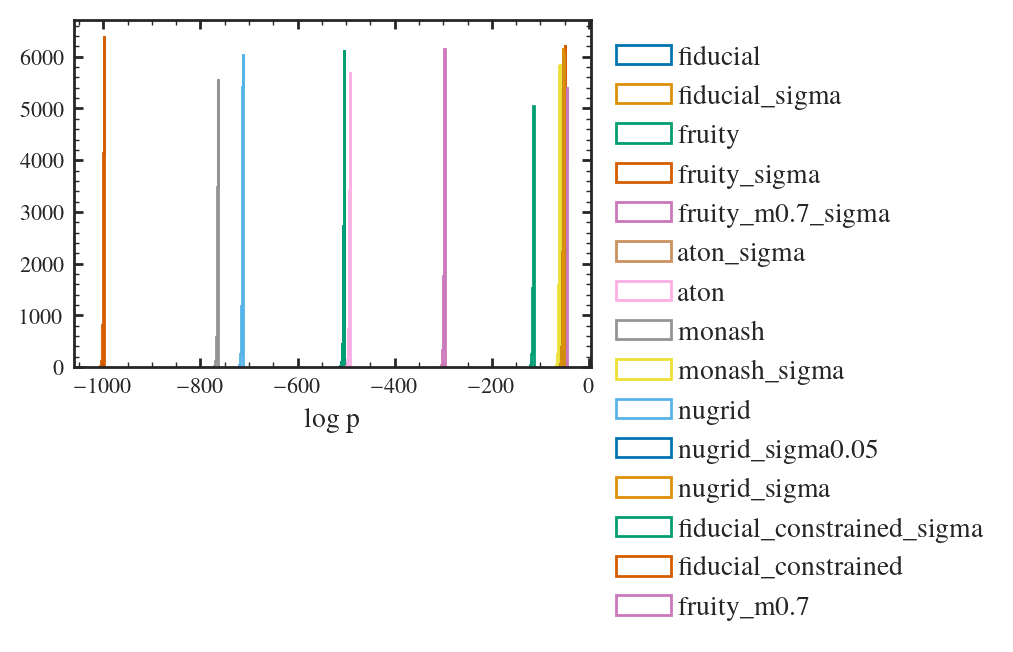

In [141]:

for label, result in results.items():
    plt.hist(result.samples.lp, label=label, histtype="step")

plt.xlabel(r"log p")
arya.Legend(-1)

In [202]:
ana = results["analytic"]

In [203]:
ana.samples.columns

Index(['iteration', 'chain', 'y0_cc', 'A_cc', 'alpha', 'zeta_cc', 'sigma_int',
       'lp', 'n_steps', 'is_accept', 'acceptance_rate', 'log_density',
       'hamiltonian_energy', 'hamiltonian_energy_error',
       'max_hamiltonian_energy_error', 'tree_depth', 'numerical_error',
       'step_size', 'nom_step_size', 'f_agb', 'y_tot', 'f_agb_a', 'y_tot_a',
       'zeta1_a'],
      dtype='object')

In [204]:
ana.samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    1.432152
zeta1_a    0.001967
dtype: float64

In [205]:
results["fruity"].samples[["zeta_cc", "zeta1_a"]].median()

zeta_cc    2.276131
zeta1_a    0.001433
dtype: float64

In [206]:
labels = {
    "fruity": r"\fruity",
    "aton": r"\aton",
    "monash": r"\monash",
    "nugrid": r"\nugrid",
    "fruity_m0.7": r"\fruity\ m0.7",
    "fruity_lin": r"\fruity\ linear",
    "eta2": r"$y\rightarrow 2y$",
    "lateburst": r"lateburst",
    "twoinfall": r"twoinfall",
    "snia_1.2": r"SN Ia 1.2",
}

In [207]:
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = ""

print(f"{'model':16} & $\\chi2$  & $\\log p$ & " + " & ".join(keys) + r"\\")
print("\\hline\\\\")

for key, label in labels.items():
    result = results[key]
    χ2 = calc_χ2(result, median=True, normalized=True)
    lp = np.max(result.samples.lp)

    
    # Add the row for χ2 and lp
    latex_table += f"{label:16} & {χ2:8.1f} & {lp:8.2f} & "

    # Extract parameter values and uncertainties
    parameter_lines = []
    for key in keys:
        if key not in result.samples.columns:
            parameter_lines.append(" ")
            continue
            
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]
        median = np.median(x)
        lower, upper = np.quantile(x, [0.16, 0.84])
        uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
        formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
        parameter_lines.append(f"{formatted_value}")
        
    latex_table += "  &  ".join(parameter_lines)
    latex_table += "\\\\ \n"

print(latex_table)

model            & $\chi2$  & $\log p$ & alpha & y0_cc & zeta_cc & A_cc & sigma_int & f_agb_a & y_tot_a & zeta1_a\\
\hline\\
\fruity          &      7.4 &    18.43 & $2.41^{+0.26}_{-0.27}$  &  $1.90^{+0.10}_{-0.09}$  &  $2.28^{+0.15}_{-0.16}$  &  $2.59^{+0.30}_{-0.30}$  &  $0.08^{+0.02}_{-0.01}$  &  $0.32^{+0.03}_{-0.04}$  &  $2.79^{+0.02}_{-0.02}$  &  $1.43^{+0.12}_{-0.13}$\\ 
\aton            &     14.9 &     5.30 & $1.71^{+0.34}_{-0.34}$  &  $2.55^{+0.05}_{-0.05}$  &  $3.19^{+0.40}_{-0.40}$  &  $1.92^{+0.45}_{-0.44}$  &  $0.14^{+0.03}_{-0.02}$  &  $0.06^{+0.01}_{-0.01}$  &  $2.72^{+0.03}_{-0.03}$  &  $1.48^{+0.20}_{-0.19}$\\ 
\monash          &     15.4 &     2.24 & $2.06^{+0.52}_{-0.54}$  &  $2.03^{+0.19}_{-0.18}$  &  $3.82^{+0.64}_{-0.66}$  &  $3.48^{+0.57}_{-0.59}$  &  $0.15^{+0.03}_{-0.02}$  &  $0.19^{+0.05}_{-0.05}$  &  $2.50^{+0.07}_{-0.07}$  &  $1.55^{+0.21}_{-0.22}$\\ 
\nugrid          &      5.8 &    24.19 & $1.21^{+0.11}_{-0.11}$  &  $1.58^{+0.11}_{-0.11}$  &  $1.58^{+0.11

In [99]:
# Total uncertanties
keys = ana.labels + ["sigma_int", "f_agb_a", "y_tot_a", "zeta1_a"]
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([x, xs])
        
    median = np.median(xs)
    lower, upper = np.quantile(xs, [0.16, 0.84])
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value

print(latex_table)

KeyError: 'A_cc'

In [ ]:
import weighted

In [ ]:
# weighted uncertanties
latex_table = "total & & "

for key in keys:
    xs = np.array([])
    ws = np.array([])
    for label, result in results.items():
        if key in ["y_tot_a", "zeta1_a"]:
            x = result.samples[key] / 1e-3
        else:
            x = result.samples[key]

        xs = np.concat([xs, x])
        ws = np.concat([ws, result.samples.lp])

        if key == "alpha":
            print(np.sum(result.samples.lp / np.log(10) > -2))

    ws = np.exp(ws)
    ws /= np.sum(ws)
    median = weighted.median(xs, ws)
    lower, upper = [weighted.quantile(xs, ws, q) for q in [0.16, 0.84]]
    uncertainty = (upper - median, median - lower)  # Asymmetric uncertainties
    formatted_value = f"${median:.2f}^{{+{uncertainty[0]:.2f}}}_{{-{uncertainty[1]:.2f}}}$"
    latex_table += "  &  " + formatted_value
    print(key, np.sum(xs * ws) / np.sum(ws))

print(latex_table)

In [ ]:
res = results["fiducial"].samples
plt.scatter(res.alpha, res.lp)

In [ ]:
plt.hist(np.log10(ws))

## Test comparisons

KeyError: 'galah'

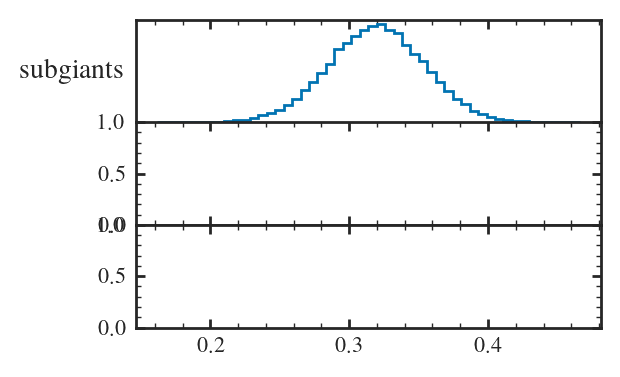

In [87]:
plot_labels = {
    "fiducial": "subgiants", 
    "galah": "galah",
    "v21": "v21",
    #"gso": "gso",
}
plot_all_params(plot_labels)

In [ ]:
results["galah"].afe

In [ ]:
plot_labels = {
    "fiducial": "subgiants", 
    "galah": "galah",
    "v21": "v21",
    "gso": "gso"
}


fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex="col", sharey=True,  gridspec_kw={"wspace": 0, "hspace": 0})

plt.sca(axs[0])
plot_samples_caah(results["fiducial"], color=arya.COLORS[0], alpha=0.01, skip=30)
for i, (key, label) in enumerate(plot_labels.items()):
    plot_samples_caah_mean(results[key], label=label, color=arya.COLORS[i])




plt.sca(axs[1])
plot_samples_caafe(results["fiducial"], color=arya.COLORS[0], alpha=0.01, skip=30)

for key, label in plot_labels.items():
    plot_samples_caafe_mean(results[key], label=label)
#plot_obs_caafe(results["analytic"], color="k")
plt.ylabel("")
plt.legend()


In [ ]:
Nr = len(plot_labels)
fig, axs = plt.subplots(Nr, 2, figsize=(6, 9), sharex="col", sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})

for i, (key, label) in enumerate(plot_labels.items()):
    ax = axs[i]
    plt.sca(axs[i][0])
    
    if key == "hline":
        continue

    result = results[key]
    
    plot_samples_caah(result)
    plt.ylabel(label, rotation=0, ha="right", va="center")


    plt.sca(axs[i][1])
    plot_samples_caafe(result)
    plt.ylabel("")

    

plt.yticks([-0.05, -0.10, -0.15, -0.20])
plt.ylim(-0.2, 0)

fig.supylabel("[C/Mg]")
plt.tight_layout()


In [ ]:
results["analytic"].labels

In [ ]:
def plot_all_params(plot_labels):
    for param in ["alpha", "zeta0", "zeta1", "zeta2"]:
        compare_param_hists(test_results, plot_labels,  param)
        plt.show()

In [ ]:
plot_labels = {
    "NUTS": "NUTS", 
    "HMC": "HMC",
    "RWMH": "RWMH",
    "add_rand_scatter": "syn scatter",
}

In [ ]:
plot_all_params(plot_labels)

In [ ]:
plot_labels = {
    "NUTS": "fiducial", 
    "fine_bins": "fine_bins",
    "superfine_bins": "superfine_bins",
    "equal_num_bins": "equal number",
    "equalnum_fine": "equal number fine",
}

In [ ]:
plot_all_params(plot_labels)

In [ ]:
plot_labels = {
    "NUTS": "fiducial", 
    "t_test": "t test",
    "2s": "both uncertanties",
}

In [ ]:
plot_all_params(plot_labels)

# Validation

In [ ]:
result = MCMCResult.from_file("analytic_quad")

In [ ]:
np.median(result.samples, axis=0)

In [ ]:

df = mz_stars[~mz_stars.high_alpha]

mg_h_bins = np.arange(-0.5, 0.31, 0.1)

bin_mids = (mg_h_bins[1:] + mg_h_bins[:-1])/2
ss = binned_statistic(df.MG_H, df.C_MG, bins=mg_h_bins, statistic="mean").statistic
se = binned_statistic(df.MG_H, df.C_MG, bins=mg_h_bins, statistic="std").statistic

In [ ]:
plot_samples_caah(result)

plt.errorbar(bin_mids, ss, yerr=se, fmt="o")

In [ ]:

df = mz_stars[(mz_stars.MG_H > -0.15 ) & (mz_stars.MG_H < -0.05)]

mg_h_bins = np.arange(0, 0.31, 0.05)

bin_mids = (mg_h_bins[1:] + mg_h_bins[:-1])/2
ss = binned_statistic(df.MG_FE, df.C_MG, bins=mg_h_bins, statistic="mean").statistic
se = binned_statistic(df.MG_FE, df.C_MG, bins=mg_h_bins, statistic="std").statistic

In [ ]:
plot_samples_caafe(result)

plt.errorbar(bin_mids, ss, yerr=se, fmt="o")